In [12]:
import numpy as np

In [ ]:
import getpass

import robin_stocks.robinhood as r

def robinhood_login(username, password):
    """
    Logs into Robinhood account using provided username and password.
    
    Parameters:
    username (str): Robinhood account username
    password (str): Robinhood account password
    
    Returns:
    dict: Login result containing access token and other details
    """
    login_result = r.login(username, password)
    return login_result

# Example usage:
# login_result = robinhood_login(rh_username, rh_password)
# print(login_result)
# Prompt for username and password

rh_username = input("Enter your Robinhood username: ")
rh_password = getpass.getpass("Enter your Robinhood password: ")

# Login to Robinhood
login_result = robinhood_login(rh_username, rh_password)
#print(login_result)

In [2]:
portfolio_data = r.profiles.load_portfolio_profile()
print(portfolio_data)

{'url': 'https://api.robinhood.com/portfolios/641067145/', 'account': 'https://api.robinhood.com/accounts/641067145/', 'start_date': '2019-01-25', 'market_value': '68049.0040', 'equity': '63169.6340', 'extended_hours_market_value': '67923.5489', 'extended_hours_equity': '63044.1789', 'extended_hours_portfolio_equity': '63044.1789', 'last_core_market_value': '68049.0040', 'last_core_equity': '63169.6340', 'last_core_portfolio_equity': '63169.6340', 'excess_margin': '21939.6320', 'excess_maintenance': '34522.0065', 'excess_margin_with_uncleared_deposits': '21939.6320', 'excess_maintenance_with_uncleared_deposits': '34522.0065', 'equity_previous_close': '64823.1600', 'portfolio_equity_previous_close': '64823.1600', 'adjusted_equity_previous_close': '64823.1600', 'adjusted_portfolio_equity_previous_close': '64823.1600', 'withdrawable_amount': '22336.29', 'unwithdrawable_deposits': '0.0000', 'unwithdrawable_grants': '0.0000', 'is_primary_account': True}


In [30]:
holdings_df = r.account.build_holdings(with_dividends=True)

In [27]:
user_profile = r.account.build_user_profile()

AttributeError: module 'robin_stocks' has no attribute 'account'

In [3]:
historical_df = r.account.get_historical_portfolio(interval='week', span='5year')

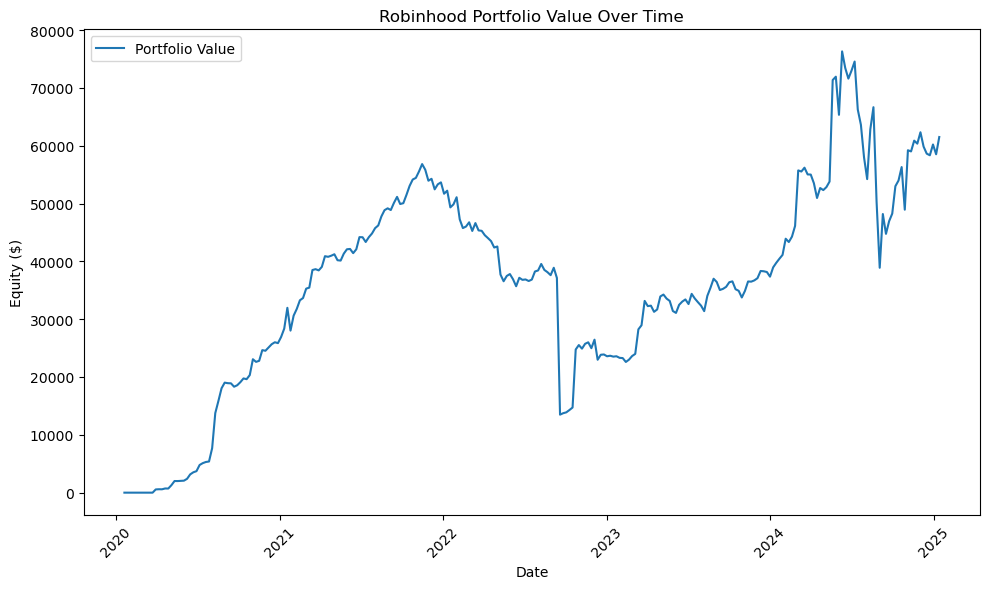

In [5]:
import pandas as pd

import matplotlib.pyplot as plt

# Convert the 'equity_historicals' list of dicts to a pandas DataFrame
historical_df = pd.DataFrame(historical_df['equity_historicals'])

# Convert 'begins_at' to datetime
historical_df['begins_at'] = pd.to_datetime(historical_df['begins_at'])

# Convert 'close_equity' field to numeric
historical_df['close_equity'] = pd.to_numeric(historical_df['close_equity'], errors='coerce')

# Sort by date
historical_df.sort_values(by='begins_at', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(historical_df['begins_at'], historical_df['close_equity'], label='Portfolio Value')
plt.title('Robinhood Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Equity ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
###############################################################################

###############################################################################
#                               DATA FETCHING
###############################################################################
def get_portfolio_history(interval='day', span='5year'):
    """
    Fetch historical portfolio data (equity value) using robin_stocks.
    Returns a pandas DataFrame with columns:
        ['timestamp', 'equity', 'adjusted_equity_previous_close']
    """
    raw_data = r.account.get_historical_portfolio(interval=interval, span=span)
    
    # 'equity_historicals' is a list of daily records
    historicals = raw_data['equity_historicals']
    
    # Convert to DataFrame
    df = pd.DataFrame(historicals)
    
    # Example fields:
    #   {
    #       'begins_at': '2023-01-01T00:00:00Z',
    #       'open_equity': '10000.00',
    #       'close_equity': '10100.00',
    #       'adjusted_equity_previous_close': '9950.00',
    #       ...
    #   }
    
    # We can choose close_equity or open_equity. 
    # Let's pick 'close_equity' to represent daily portfolio value:
    df['timestamp'] = pd.to_datetime(df['begins_at'], utc=True).dt.tz_convert(None)
    df['equity'] = df['close_equity'].astype(float)
    #df['adjusted_equity_previous_close'] = df['adjusted_equity_previous_close'].astype(float)
    
    # Keep only necessary columns
    df = df[['timestamp', 'equity']]
    
    # Sort by date ascending
    df = df.sort_values('timestamp').reset_index(drop=True)
    return df


def get_ticker_history(ticker, interval='day', span='5year'):
    """
    Fetch historical data for a given ticker (e.g. SPY, ARKK) using robin_stocks.
    Returns a pandas DataFrame with columns:
        ['timestamp', 'close_price']
    """
    raw_data = r.stocks.get_stock_historicals(
        ticker,
        interval=interval,
        span=span,
        bounds='regular'
    )
    
    # Convert to DataFrame
    df = pd.DataFrame(raw_data)
    
    # Example fields per record:
    #   {
    #       'begins_at': '2023-01-01T00:00:00Z',
    #       'close_price': '400.00',
    #       'open_price': '398.00',
    #       ...
    #   }
    
    df['timestamp'] = pd.to_datetime(df['begins_at'], utc=True).dt.tz_convert(None)
    df['close_price'] = df['close_price'].astype(float)
    
    # Keep only necessary columns
    df = df[['timestamp', 'close_price']]
    
    # Sort by date ascending
    df = df.sort_values('timestamp').reset_index(drop=True)
    return df


###############################################################################
#                          DATA PROCESSING HELPERS
###############################################################################
def filter_by_year(df, year):
    """
    Returns a slice of DataFrame for a specific calendar year.
    Expects a 'timestamp' column in df.
    """
    start = pd.Timestamp(f'{year}-01-01')
    end = pd.Timestamp(f'{year}-12-31 23:59:59')
    return df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].copy()


def filter_by_date_range(df, start_date, end_date):
    """
    Returns data between start_date and end_date (inclusive).
    start_date/end_date can be strings or Timestamps.
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    return df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].copy()


def calculate_daily_returns(df, price_col='equity'):
    """
    Given a DataFrame with a date-based index or a 'timestamp' column
    and a price column (close_price, equity, etc.),
    compute daily returns = (price_today / price_yesterday) - 1.
    Returns a pd.Series of daily returns.
    """
    df = df.copy()
    df = df.sort_values('timestamp')
    df['daily_return'] = df[price_col].pct_change()
    return df['daily_return'].dropna()


###############################################################################
#                         PERFORMANCE METRICS CLASSES
###############################################################################
class PerformanceMetrics:
    """
    Class holding static methods to compute various performance metrics.
    """
    
    @staticmethod
    def annual_return(daily_returns):
        """
        Approximate annual return given daily returns.
        If daily_returns is for 1 full year, this yields that year's total return.
        """
        # Convert daily returns to total return factor
        cum_return_factor = (1 + daily_returns).prod()
        # For single-year data, this is simply (cum_return_factor - 1).
        # For partial year or multiple years, you may want to scale by # of trading days, etc.
        return cum_return_factor - 1.0
    
    @staticmethod
    def annualized_volatility(daily_returns, trading_days=252):
        """
        Compute annualized standard deviation of returns.
        """
        return daily_returns.std() * np.sqrt(trading_days)
    
    @staticmethod
    def sharpe_ratio(daily_returns, risk_free_rate=0.02, trading_days=252):
        """
        Sharpe Ratio = (Rp - Rf) / sigma,
        where Rf is risk-free rate, assumed annual,
        and we scale daily Rf to daily basis for convenience.
        """
        # Convert annual risk-free rate to daily
        daily_rf = (1 + risk_free_rate)**(1/trading_days) - 1
        
        excess_return_daily = daily_returns - daily_rf
        mean_excess = excess_return_daily.mean()
        std_excess = excess_return_daily.std()
        
        # annualize the mean_excess
        annual_excess = mean_excess * trading_days
        annual_std = std_excess * np.sqrt(trading_days)
        
        if annual_std == 0:
            return np.nan
        
        return annual_excess / annual_std
    
    @staticmethod
    def beta_alpha(portfolio_returns, market_returns, risk_free_rate=0.02, trading_days=252):
        """
        Compute Beta and Alpha using a simple linear regression with the CAPM model:
            (Rp - Rf) = alpha + beta * (Rm - Rf).
        
        Returns a tuple: (beta, alpha)
        - alpha is annualized
        - beta is slope of regression
        """
        # Convert to aligned series
        df = pd.DataFrame({
            'portfolio': portfolio_returns,
            'market': market_returns
        }).dropna()
        
        # If insufficient data, return None
        if len(df) < 2:
            return (np.nan, np.nan)
        
        daily_rf = (1 + risk_free_rate)**(1/trading_days) - 1
        
        df['excess_portfolio'] = df['portfolio'] - daily_rf
        df['excess_market'] = df['market'] - daily_rf
        
        # Perform linear regression: y = alpha + beta * x
        # Using np.polyfit on (excess_market, excess_portfolio)
        # slope = beta, intercept = alpha (but this alpha is daily alpha in decimal form)
        beta, alpha_daily = np.polyfit(df['excess_market'], df['excess_portfolio'], 1)
        
        # Annualize alpha (rough approximation by scaling daily alpha * 252)
        alpha_annual = alpha_daily * trading_days
        
        return beta, alpha_annual
    
    @staticmethod
    def max_drawdown(series):
        """
        Calculate the maximum drawdown of a time series of values (e.g. cumulative equity).
        The minimum value must occur after the peak value.
        """
        # Calculate the running maximum
        running_max = series.cummax()
        
        # Calculate the drawdown
        drawdown = (series - running_max) / running_max
        
        # The maximum drawdown is the minimum value of the drawdown series
        max_drawdown = drawdown.min()
        
        return max_drawdown


###############################################################################
#                 MAIN ANALYSIS FUNCTION (BY YEAR + CUMULATIVE)
###############################################################################
def analyze_portfolio_performance(
    start_year=2020,
    end_year=2024,
    interval='day',
    span='5year',
    risk_free_rate=0.02
):
    """
    1. Fetch portfolio data from Robinhood (5 years daily).
    2. Fetch SPY (S&P 500) and ARKK as benchmarks over the same period.
    3. For each year in [start_year, end_year], compute:
       - Annual Return
       - Sharpe Ratio
       - Beta, Alpha (vs. SPY)
       - Max Drawdown
    4. Also compute the same metrics for the entire [start_year-01-01, end_year-12-31] range.
    
    Returns a dict of results for each year, plus "Cumulative".
    """
    # --------------------- Fetch Data ---------------------
    ticker_histories = {
        'portfolio': get_portfolio_history(interval=interval, span=span),
        'ARKK': get_ticker_history('ARKK', interval=interval, span=span),
        'SPY': get_ticker_history('SPY', interval=interval, span=span),
        'DIA': get_ticker_history('DIA', interval=interval, span=span),
        'QQQ': get_ticker_history('QQQ', interval=interval, span=span),
        'IWM': get_ticker_history('IWM', interval=interval, span=span)  # Russell 2000 ETF
    }

    #df_portfolio = ticker_histories['portfolio']
    #df_spy = ticker_histories['SPY']
    #df_dia = ticker_histories['DIA']
    #df_qqq = ticker_histories['QQQ']
    #df_iwm = ticker_histories['IWM']

    
    # --------------------- Storage for results ---------------------
    yearly_results = {}
    
    # --------------------- Process each year individually ---------------------
    for year in range(start_year, end_year + 1):
        # Filter data for that year
        df_p_yr = filter_by_year(ticker_histories['portfolio'], year)
        df_spy_yr = filter_by_year(ticker_histories['SPY'], year)
        df_arkk_yr = filter_by_year(ticker_histories['ARKK'], year)
        
        # Calculate daily returns
        port_ret_yr = calculate_daily_returns(df_p_yr, 'equity')
        spy_ret_yr = calculate_daily_returns(df_spy_yr, 'close_price')
        arkk_ret_yr = calculate_daily_returns(df_arkk_yr, 'close_price')
        
        # If no data for a given year, skip
        if len(port_ret_yr) == 0:
            continue
        
        # Annual Return
        ann_ret = PerformanceMetrics.annual_return(port_ret_yr)
        
        # Sharpe Ratio
        sh_ratio = PerformanceMetrics.sharpe_ratio(
            port_ret_yr, 
            risk_free_rate=risk_free_rate
        )
        
        # Beta, Alpha (vs. SPY)
        beta_spy, alpha_spy = PerformanceMetrics.beta_alpha(
            port_ret_yr, 
            spy_ret_yr, 
            risk_free_rate=risk_free_rate
        )
        
        # Max Drawdown
        # We need the equity time-series to compute drawdown
        max_dd = np.nan
        if len(df_p_yr) > 0:
            max_dd = PerformanceMetrics.max_drawdown(df_p_yr['equity'])
        
        yearly_results[year] = {
            'Annual Return': ann_ret,
            'Sharpe Ratio': sh_ratio,
            'Beta (vs SPY)': beta_spy,
            'Alpha (vs SPY)': alpha_spy,
            'Max Drawdown': max_dd
        }
    
    # --------------------- Process Cumulative Period ---------------------
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    
    df_p_cum = filter_by_date_range(ticker_histories['portfolio'], start_date, end_date)
    df_spy_cum = filter_by_date_range(ticker_histories['SPY'], start_date, end_date)
    df_arkk_cum = filter_by_date_range(ticker_histories['SPY'], start_date, end_date)
    
    port_ret_cum = calculate_daily_returns(df_p_cum, 'equity')
    spy_ret_cum = calculate_daily_returns(df_spy_cum, 'close_price')
    arkk_ret_cum = calculate_daily_returns(df_arkk_cum, 'close_price')
    
    # Annual return for entire period (approx)
    # This is a multi-year period, so you could do a geometric return approach:
    total_days = (df_p_cum['timestamp'].max() - df_p_cum['timestamp'].min()).days
    trading_days_per_year = 252
    
    if len(port_ret_cum) > 0:
        # Cumulative total return factor
        cum_factor = (1 + port_ret_cum).prod()
        # Approx # of years in this range
        years_in_period = total_days / 365.0
        
        # Geometric annualized return:
        ann_ret_cum = cum_factor**(1/years_in_period) - 1
        
        # Sharpe (annualized)
        sh_ratio_cum = PerformanceMetrics.sharpe_ratio(
            port_ret_cum, 
            risk_free_rate=risk_free_rate,
            trading_days=trading_days_per_year
        )
        
        # Beta, Alpha (vs SPY)
        beta_spy_cum, alpha_spy_cum = PerformanceMetrics.beta_alpha(
            port_ret_cum, 
            spy_ret_cum,
            risk_free_rate=risk_free_rate,
            trading_days=trading_days_per_year
        )
        
        # Max Drawdown
        max_dd_cum = PerformanceMetrics.max_drawdown(df_p_cum['equity'])
    else:
        ann_ret_cum = np.nan
        sh_ratio_cum = np.nan
        beta_spy_cum = np.nan
        alpha_spy_cum = np.nan
        max_dd_cum = np.nan
    
    yearly_results['Cumulative'] = {
        'Annual Return': ann_ret_cum,
        'Sharpe Ratio': sh_ratio_cum,
        'Beta (vs SPY)': beta_spy_cum,
        'Alpha (vs SPY)': alpha_spy_cum,
        'Max Drawdown': max_dd_cum
    }
    
    return yearly_results


In [18]:
def analyze_portfolio_performance(
    entity='portfolio',
    start_year=2020,
    end_year=2024,
    interval='day',
    span='5year',
    risk_free_rate=0.02
):
    """
    1. If entity == 'portfolio', fetch your personal portfolio data from Robinhood.
       Otherwise, fetch the specified ticker (e.g. 'SPY', 'AAPL', etc.)
    2. Fetch SPY (S&P 500) and ARKK as benchmarks over the same period.
    3. For each year in [start_year, end_year], compute:
       - Annual Return
       - Sharpe Ratio
       - Beta, Alpha (vs. SPY)
       - Max Drawdown
    4. Also compute the same metrics for the entire [start_year-01-01, end_year-12-31] range.
    
    Returns a dict of results for each year, plus "Cumulative".
    """
    # --------------------- Fetch Data ---------------------
    if entity == 'portfolio':
        data = get_portfolio_history(interval=interval, span=span)
    else:
        data = get_ticker_history(entity, interval=interval, span=span)
    
    ticker_histories = {
        'entity': data,
        'ARKK': get_ticker_history('ARKK', interval=interval, span=span),
        'SPY':  get_ticker_history('SPY', interval=interval, span=span),
        'DIA':  get_ticker_history('DIA', interval=interval, span=span),
        'QQQ':  get_ticker_history('QQQ', interval=interval, span=span),
        'IWM':  get_ticker_history('IWM', interval=interval, span=span)  # Russell 2000 ETF
    }

    # --------------------- Storage for results ---------------------
    yearly_results = {}
    
    # --------------------- Process each year individually ---------------------
    for year in range(start_year, end_year + 1):
        # Filter data for that year
        df_entity_yr = filter_by_year(ticker_histories['entity'], year)
        df_spy_yr    = filter_by_year(ticker_histories['SPY'], year)
        df_arkk_yr   = filter_by_year(ticker_histories['ARKK'], year)
        
        # Calculate daily returns
        # Use 'equity' if it's the portfolio, else 'close_price'
        entity_col = 'equity' if entity == 'portfolio' else 'close_price'
        entity_ret_yr = calculate_daily_returns(df_entity_yr, entity_col)
        spy_ret_yr    = calculate_daily_returns(df_spy_yr, 'close_price')
        arkk_ret_yr   = calculate_daily_returns(df_arkk_yr, 'close_price')
        
        # If no data for this year, skip
        if len(entity_ret_yr) == 0:
            continue
        
        # Annual Return
        ann_ret = PerformanceMetrics.annual_return(entity_ret_yr)
        
        # Sharpe Ratio
        sh_ratio = PerformanceMetrics.sharpe_ratio(
            entity_ret_yr, 
            risk_free_rate=risk_free_rate
        )
        
        # Beta, Alpha (vs. SPY)
        beta_spy, alpha_spy = PerformanceMetrics.beta_alpha(
            entity_ret_yr, 
            spy_ret_yr, 
            risk_free_rate=risk_free_rate
        )
        
        # Max Drawdown (need the actual price column to compute)
        max_dd = np.nan
        if len(df_entity_yr) > 0:
            max_dd = PerformanceMetrics.max_drawdown(df_entity_yr[entity_col])
        
        yearly_results[year] = {
            'Annual Return': ann_ret,
            'Sharpe Ratio': sh_ratio,
            'Beta (vs SPY)': beta_spy,
            'Alpha (vs SPY)': alpha_spy,
            'Max Drawdown': max_dd
        }
    
    # --------------------- Process Cumulative Period ---------------------
    start_date = f'{start_year}-01-01'
    end_date   = f'{end_year}-12-31'
    
    df_entity_cum = filter_by_date_range(ticker_histories['entity'], start_date, end_date)
    df_spy_cum    = filter_by_date_range(ticker_histories['SPY'], start_date, end_date)
    df_arkk_cum   = filter_by_date_range(ticker_histories['ARKK'], start_date, end_date)

    entity_ret_cum = calculate_daily_returns(df_entity_cum, entity_col)
    spy_ret_cum    = calculate_daily_returns(df_spy_cum, 'close_price')
    arkk_ret_cum   = calculate_daily_returns(df_arkk_cum, 'close_price')
    
    # Annual return for entire multi-year period
    total_days = (df_entity_cum['timestamp'].max() - df_entity_cum['timestamp'].min()).days
    trading_days_per_year = 252
    
    if len(entity_ret_cum) > 0:
        # Cumulative total return factor
        cum_factor = (1 + entity_ret_cum).prod()
        # Approx # of years in the range
        years_in_period = total_days / 365.0
        
        # Geometric annualized return:
        ann_ret_cum = cum_factor ** (1 / years_in_period) - 1
        
        # Sharpe (annualized)
        sh_ratio_cum = PerformanceMetrics.sharpe_ratio(
            entity_ret_cum, 
            risk_free_rate=risk_free_rate,
            trading_days=trading_days_per_year
        )
        
        # Beta, Alpha (vs. SPY)
        beta_spy_cum, alpha_spy_cum = PerformanceMetrics.beta_alpha(
            entity_ret_cum, 
            spy_ret_cum, 
            risk_free_rate=risk_free_rate,
            trading_days=trading_days_per_year
        )
        
        # Max Drawdown
        max_dd_cum = PerformanceMetrics.max_drawdown(df_entity_cum[entity_col])
        
        yearly_results['Cumulative'] = {
            'Annualized Return': ann_ret_cum,
            'Sharpe Ratio': sh_ratio_cum,
            'Beta (vs SPY)': beta_spy_cum,
            'Alpha (vs SPY)': alpha_spy_cum,
            'Max Drawdown': max_dd_cum
        }
    
    return yearly_results


In [32]:

indices = ['SPY', 'DIA', 'QQQ', 'VOO', 'IWM', 'BRK.B', 'VUG', 'VGT', 'ARKK']

results = {}

for index in indices:
    results[index] = analyze_portfolio_performance(
        entity=index,
        start_year=2020,
        end_year=2024,     # future-dated if you want the script to keep going
        interval='day',
        span='5year',
        risk_free_rate=0.02
    )

results['portfolio']  = analyze_portfolio_performance(
    entity='portfolio',
    start_year=2020,
    end_year=2024,     # future-dated if you want the script to keep going
    interval='day',
    span='5year',
    risk_free_rate=0.02
)

In [34]:
results['ARKK']  = analyze_portfolio_performance(
    entity='ARKK',
    start_year=2020,
    end_year=2024,     # future-dated if you want the script to keep going
    interval='day',
    span='5year',
    risk_free_rate=0.02
)

In [20]:
results

{'ARKK': {2020: {'Annual Return': 1.3577651515151512,
   'Sharpe Ratio': 2.0314832371097733,
   'Beta (vs SPY)': 1.147791953727379,
   'Alpha (vs SPY)': 0.819375695276557,
   'Max Drawdown': -0.4253768428027166},
  2021: {'Annual Return': -0.241398668698372,
   'Sharpe Ratio': -0.5495595480611094,
   'Beta (vs SPY)': 1.6052546489196595,
   'Alpha (vs SPY)': -0.6082113513982756,
   'Max Drawdown': -0.41327117128624347},
  2022: {'Annual Return': -0.6779049386534688,
   'Sharpe Ratio': -1.3736165022105573,
   'Beta (vs SPY)': 2.1225794415942048,
   'Alpha (vs SPY)': -0.47666358534130226,
   'Max Drawdown': -0.6944014846891432},
  2023: {'Annual Return': 0.7193040052527915,
   'Sharpe Ratio': 1.5117067201843188,
   'Beta (vs SPY)': 2.207143929633718,
   'Alpha (vs SPY)': 0.13918301574452263,
   'Max Drawdown': -0.32675222112537017},
  2024: {'Annual Return': 0.12415841584158427,
   'Sharpe Ratio': 0.4515468754168515,
   'Beta (vs SPY)': 2.1116863412418554,
   'Alpha (vs SPY)': -0.26952034

In [22]:
results_df

,Annual Return,Sharpe Ratio,Beta (vs SPY),Alpha (vs SPY),Max Drawdown,Year,Entity,Annualized Return
0,1.357765,2.031483,1.147792,0.819376,-0.425377,2020,ARKK,NaN
1,-0.241399,-0.549560,1.605255,-0.608211,-0.413271,2021,ARKK,NaN
2,-0.677905,-1.373617,2.122579,-0.476664,-0.694401,2022,ARKK,NaN
3,0.719304,1.511707,2.207144,0.139183,-0.326752,2023,ARKK,NaN
4,0.124158,0.451547,2.111686,-0.269520,-0.235670,2024,ARKK,NaN
5,NaN,0.231018,1.596710,-0.080247,-0.810704,Cumulative,ARKK,0.014785
6,29053.417685,1.037450,191.808206,690.401597,-0.082564,2020,portfolio,NaN
7,1.040010,1.570877,0.173619,0.813677,-0.373919,2021,portfolio,NaN
8,-0.552705,-0.259415,0.855539,-0.070716,-0.752155,2022,portfolio,NaN
9,0.606062,1.444032,0.179447,0.485761,-0.152403,2023,portfolio,NaN


In [35]:
import pandas as pd

import plotly.express as px

# Flatten the nested results dictionary
flattened_results = []
for entity, yearly_data in results.items():
    for year, metrics in yearly_data.items():
        metrics['Year'] = year
        metrics['Entity'] = entity
        flattened_results.append(metrics)

# Convert the flattened list of dictionaries into a DataFrame
results_df = pd.DataFrame(flattened_results)

# Filter after 2020
results_df = results_df[results_df['Year'] != 2020]

# Plot the data using Plotly
fig = px.line(results_df, x='Year', y='Annual Return', color='Entity', title='Annual Return Over Time')
fig.show()

fig = px.line(results_df, x='Year', y='Sharpe Ratio', color='Entity', title='Sharpe Ratio Over Time')
fig.show()

fig = px.line(results_df, x='Year', y='Beta (vs SPY)', color='Entity', title='Beta (vs SPY) Over Time')
fig.show()

fig = px.line(results_df, x='Year', y='Alpha (vs SPY)', color='Entity', title='Alpha (vs SPY) Over Time')
fig.show()

fig = px.line(results_df, x='Year', y='Max Drawdown', color='Entity', title='Max Drawdown Over Time')
fig.show()

In [37]:
results_df[results_df['Year']=='Cumulative'].sort_values('Annualized Return', ascending=False)

,Annual Return,Sharpe Ratio,Beta (vs SPY),Alpha (vs SPY),Max Drawdown,Year,Entity,Annualized Return
53,NaN,0.454316,98.191678,1.267779e+02,-0.767848,Cumulative,portfolio,8.403189
47,NaN,0.716984,-0.224024,2.287567e-01,-0.354559,Cumulative,VGT,0.199019
17,NaN,0.706809,1.129088,4.662048e-02,-0.356172,Cumulative,QQQ,0.183205
41,NaN,0.676610,-0.184764,1.939499e-01,-0.359966,Cumulative,VUG,0.172156
35,NaN,0.682367,-0.147776,1.662755e-01,-0.293890,Cumulative,BRK.B,0.155275
23,NaN,0.580076,-0.164267,1.438174e-01,-0.343014,Cumulative,VOO,0.128200
5,NaN,0.566676,1.000000,6.374228e-17,-0.341047,Cumulative,SPY,0.124154
11,NaN,0.384062,0.930568,-3.182974e-02,-0.370587,Cumulative,DIA,0.080855
29,NaN,0.280169,1.120543,-5.741169e-02,-0.408210,Cumulative,IWM,0.060396
59,NaN,0.231018,1.596710,-8.024715e-02,-0.810704,Cumulative,ARKK,0.014785
